# Test Cuda

In [1]:
import torch
x = torch.rand(5, 3)
print(x)
torch.cuda.is_available()

tensor([[0.6998, 0.3888, 0.4468],
        [0.1164, 0.0433, 0.0544],
        [0.6743, 0.5442, 0.5176],
        [0.6299, 0.0159, 0.2796],
        [0.6444, 0.8762, 0.0720]])


True

# Data Preprocessing

In [2]:
import pandas
train_df = pandas.read_csv("train.csv")
test_df = pandas.read_csv("test.csv")

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In further steps we need to clean string data:
- sex
- ticket
- fare
- cabin
- embarked
Also we need to check for empty values.

In [4]:
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### First look at the data:
- We probably drop passengerId because it is unlikely that this column introduces information for solving this problem.
- The name column is hard to interprete. We could split the string value and only use the first part since it appear to be the last name.
    - We then could further check if this last name is unique
    - We could also infer if a person with the same name survived and analyze if this introduces information. Since deep nn is used i will not do this. But classical ml algorithms may profit from this.
- Since the ticket number is not easily formatted i will remove it. One may be able to get gain information out of this column. maybe using embeddings?
- For the cabin we could convert values into numerical representations. Maybe by just converting the alph characters to numbers from 1 to 26.

In [5]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

There are few columns with NA:
- For the age we could either use a default value indicating no value e.g 0 or for example just use an average or median. I dont believe the age is following a normal but since i dont know i will use the average.
- For the cabin we use the mode. At the end of the evaluation one could try using a additional value representing no value.
- For embarked we also use the mode.

In [6]:
train_df.groupby(["Sex"]).size()

Sex
female    314
male      577
dtype: int64

In [7]:
train_df.groupby(["Embarked"]).size()

Embarked
C    168
Q     77
S    644
dtype: int64

In [8]:
# convert age NA to mean
train_df["Age"] = train_df["Age"].fillna(train_df["Age"].mean())
# convert embarked to mode
train_df["Embarked"] = train_df["Embarked"].fillna(train_df["Embarked"].mode()[0])
# map sex to new numeric col
train_df["sex_numeric"] = train_df["Sex"].map({"male": 0, "female": 1})
# map embarked to new numberic col
train_df["embarked_numeric"] = train_df["Embarked"].map({"C": 0, "Q": 1,"S": 2})
# split first part of name (last name) into new colum
train_df["Name_first_part"] = train_df["Name"].str.split(",").str[0]
# add new numeric col which represents uniqueness of the lastnae
train_df['name_unique'] = train_df['Name_first_part'].duplicated(keep=False).astype(int)

In [9]:
train_df.isna().sum()

PassengerId           0
Survived              0
Pclass                0
Name                  0
Sex                   0
Age                   0
SibSp                 0
Parch                 0
Ticket                0
Fare                  0
Cabin               687
Embarked              0
sex_numeric           0
embarked_numeric      0
Name_first_part       0
name_unique           0
dtype: int64

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PassengerId       891 non-null    int64  
 1   Survived          891 non-null    int64  
 2   Pclass            891 non-null    int64  
 3   Name              891 non-null    object 
 4   Sex               891 non-null    object 
 5   Age               891 non-null    float64
 6   SibSp             891 non-null    int64  
 7   Parch             891 non-null    int64  
 8   Ticket            891 non-null    object 
 9   Fare              891 non-null    float64
 10  Cabin             204 non-null    object 
 11  Embarked          891 non-null    object 
 12  sex_numeric       891 non-null    int64  
 13  embarked_numeric  891 non-null    int64  
 14  Name_first_part   891 non-null    object 
 15  name_unique       891 non-null    int64  
dtypes: float64(2), int64(8), object(6)
memory us

In [11]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,sex_numeric,embarked_numeric,name_unique
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.352413,1.536476,0.400673
std,257.353842,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429,0.477990,0.791503,0.490310
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,1.000000,0.000000
50%,446.000000,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200,0.000000,2.000000,0.000000
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,1.000000,2.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,2.000000,1.000000


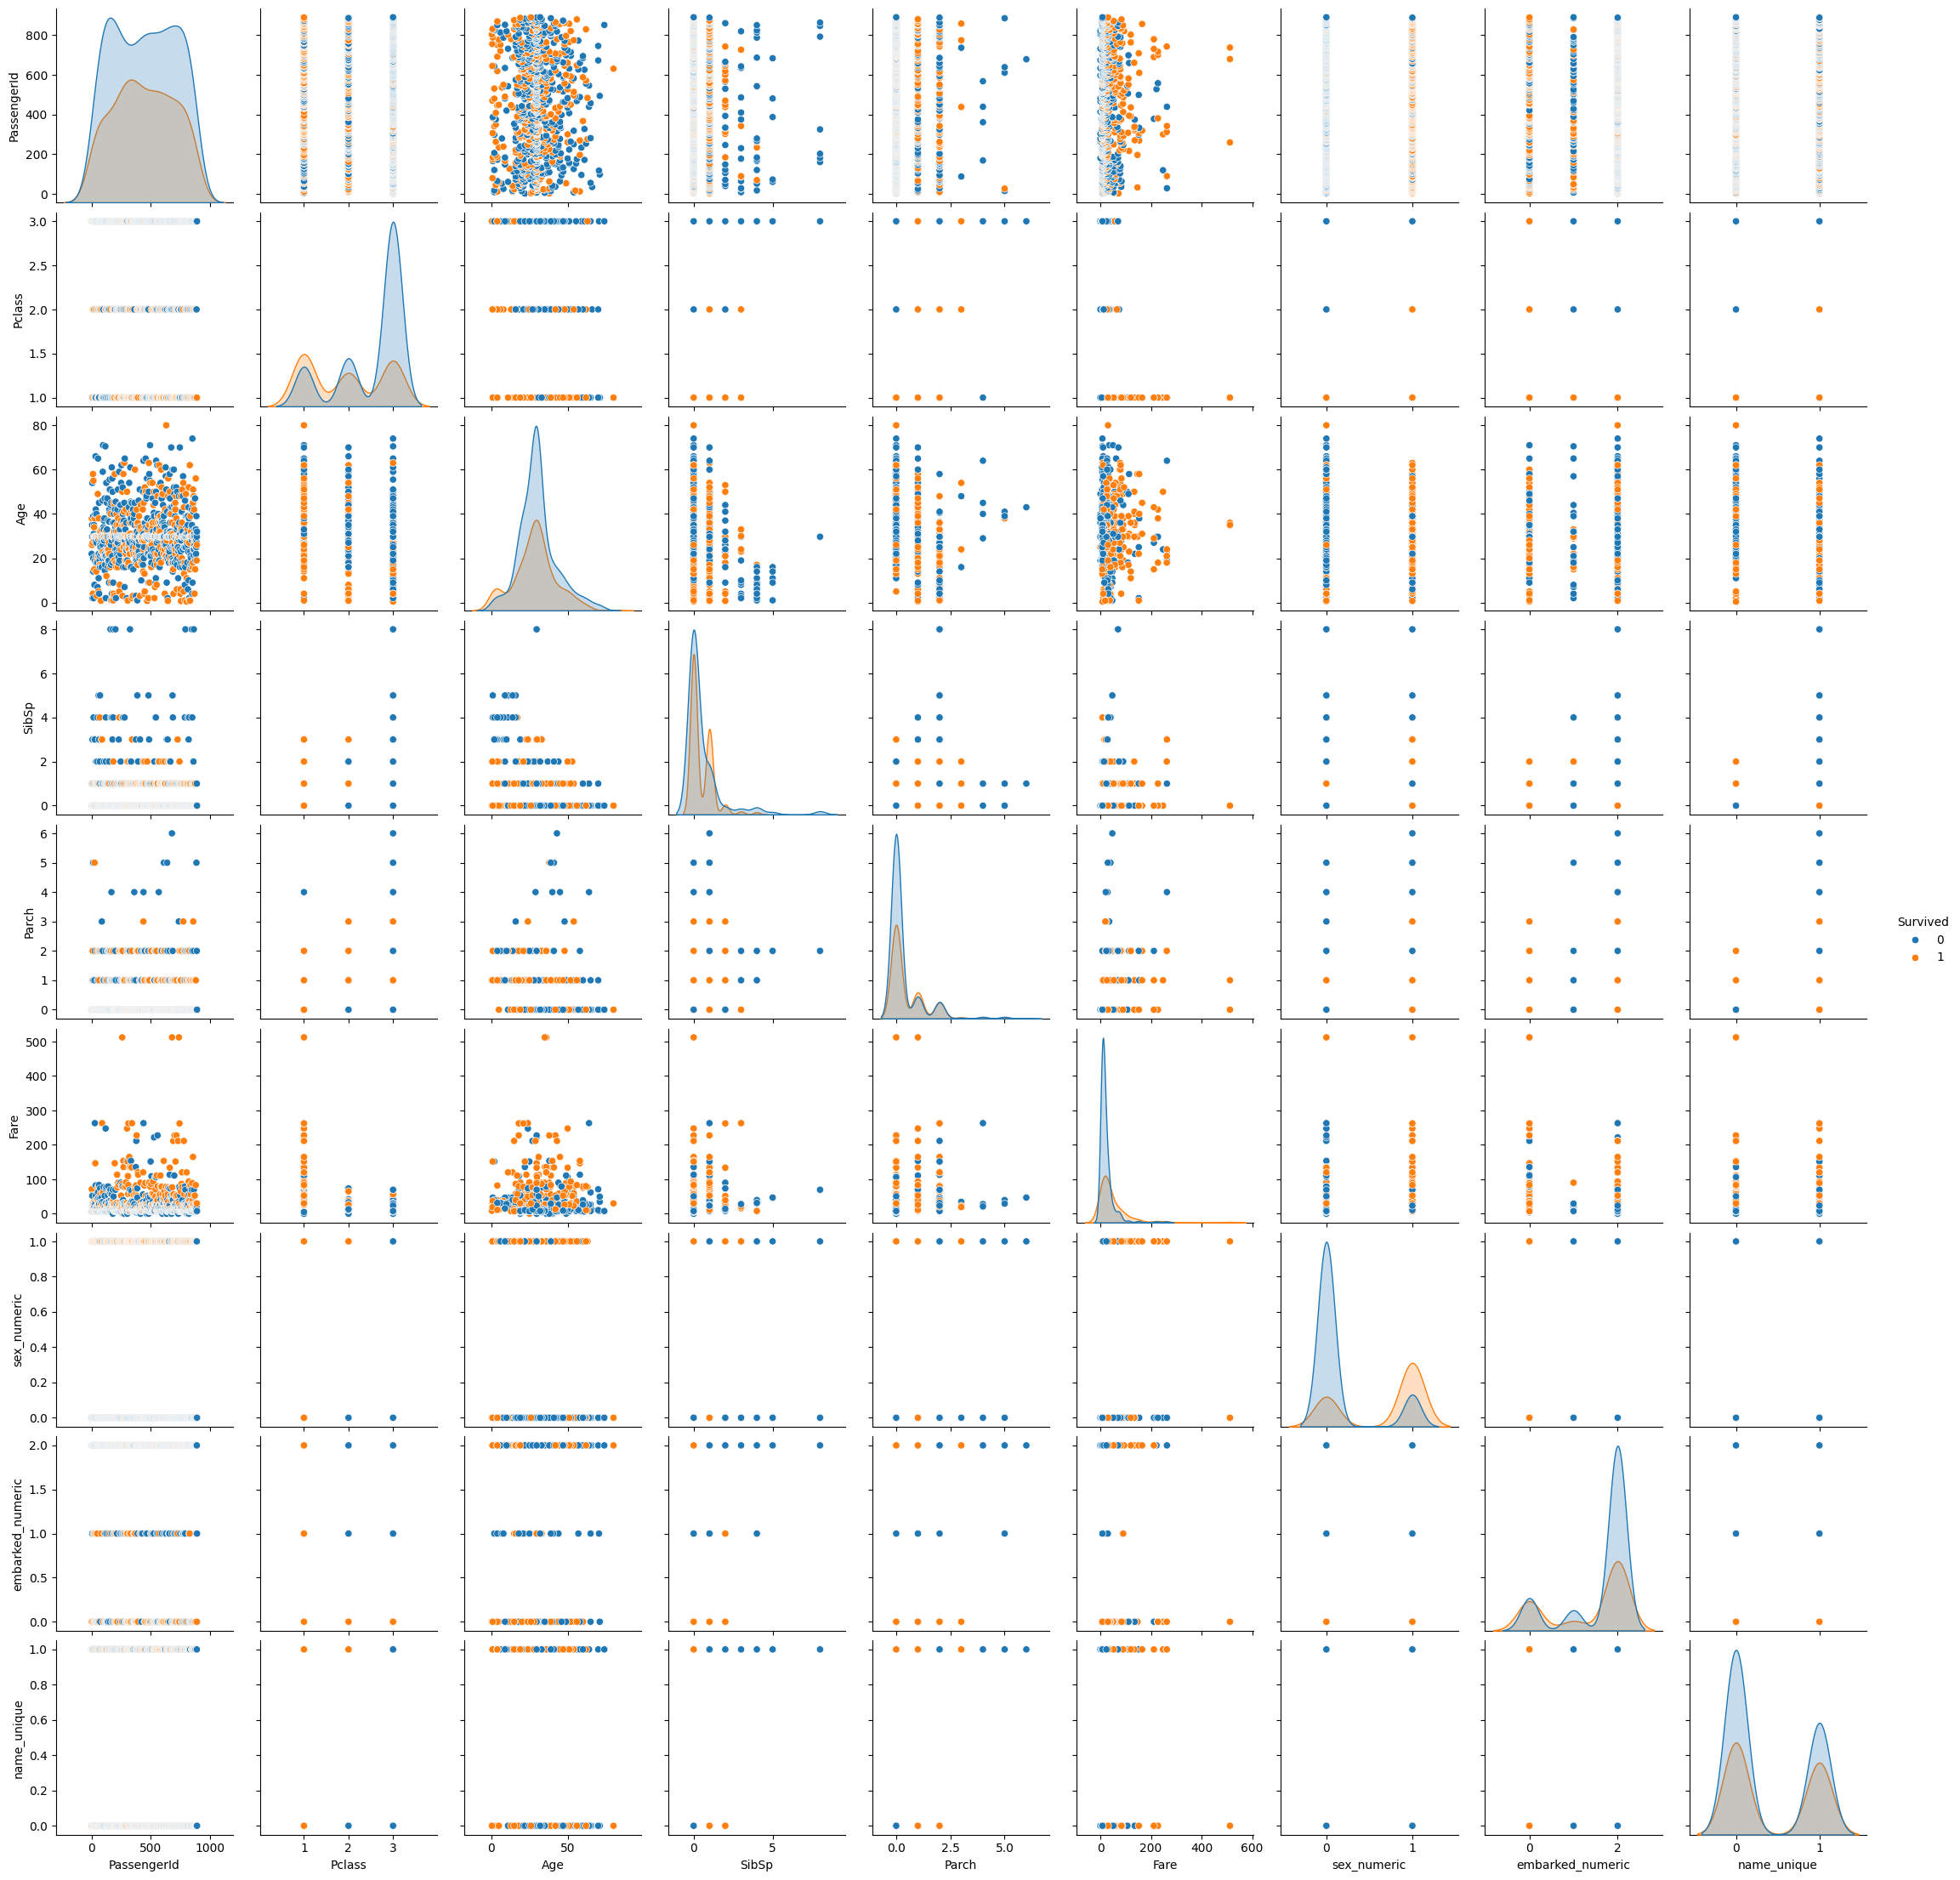

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot to visualize pairwise relationships and correlations
sns.pairplot(train_df, hue="Survived")
plt.show()

## Training Dataset

In [13]:
X = train_df[['Pclass','Age','SibSp','Parch','Fare','sex_numeric','embarked_numeric','name_unique']]
Y = train_df['Survived']

In [14]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

def lazy_predict(X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)
    return models, predictions

lazy_predict(X, Y)

100%|██████████| 32/32 [00:00<00:00, 36.16it/s]

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


(                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
 Model                                                                           
 LGBMClassifier                     0.83               0.82     0.82      0.83   
 QuadraticDiscriminantAnalysis      0.82               0.81     0.81      0.82   
 SVC                                0.82               0.81     0.81      0.82   
 ExtraTreesClassifier               0.82               0.81     0.81      0.82   
 NuSVC                              0.82               0.80     0.80      0.81   
 RandomForestClassifier             0.81               0.80     0.80      0.81   
 KNeighborsClassifier               0.80               0.80     0.80      0.80   
 LabelSpreading                     0.80               0.79     0.79      0.80   
 LogisticRegression                 0.80               0.79     0.79      0.80   
 AdaBoostClassifier                 0.80               0.78     0.78      0.80   
 LabelPropagatio

In [15]:
import statsmodels.api as sm
correlation_matrix = X.corr()
print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                  Pclass   Age  SibSp  Parch  Fare  sex_numeric  \
Pclass              1.00 -0.33   0.08   0.02 -0.55        -0.13   
Age                -0.33  1.00  -0.23  -0.18  0.09        -0.08   
SibSp               0.08 -0.23   1.00   0.41  0.16         0.11   
Parch               0.02 -0.18   0.41   1.00  0.22         0.25   
Fare               -0.55  0.09   0.16   0.22  1.00         0.18   
sex_numeric        -0.13 -0.08   0.11   0.25  0.18         1.00   
embarked_numeric    0.16 -0.03   0.07   0.04 -0.22        -0.11   
name_unique         0.02 -0.18   0.46   0.46  0.13         0.16   

                  embarked_numeric  name_unique  
Pclass                        0.16         0.02  
Age                          -0.03        -0.18  
SibSp                         0.07         0.46  
Parch                         0.04         0.46  
Fare                         -0.22         0.13  
sex_numeric                  -0.11         0.16  
embarked_numeric          

- Strong negative correlation: Pclass and Fare (-0.55) — this is a clear, meaningful relationship.
- Moderate correlations: SibSp and Parch (0.41) and Parch and name_unique (0.46).

# Dataset

In [70]:
from torch.utils.data import Dataset
class TitanicDataset(Dataset):
    def __init__(self, X, Y):
        # Convert the features and labels into torch tensors
        self.X = torch.tensor(X.values, dtype=torch.float32)  # Convert DataFrame to tensor
        self.Y = torch.tensor(Y.values, dtype=torch.float)  # Convert labels to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [71]:
from torch import nn
    
class NeuralNetwork(nn.Module):
    def __init__(self,feature_size):
        super().__init__()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(feature_size, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [29]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
NeuralNetwork                            --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       144
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       136
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       36
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       5
Total params: 321
Trainable params: 321
Non-trainable params: 0

In [ ]:
from torch.utils.data import DataLoader

learning_rate = 1e-3
batch_size = 8
epochs = 5

dataset = TitanicDataset(X, Y)
test_dataset = TitanicDataset()
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
#device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
#print(f"Using {device} device")
model = NeuralNetwork(8) #.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (features, labels) in enumerate(dataloader):
        print(features.shape)
        print(labels.shape) 
        
        pred = model(features)
        print(pred)
        print(labels)
        
        # Make sure Y_batch is in the correct shape
        Y_batch = labels.unsqueeze(1)  # Add a dimension to make shape [batch_size, 1]
        
        loss = loss_fn(pred, Y_batch)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
torch.Size([8, 8])
torch.Size([8])
tensor([[-0.8317],
        [-0.6009],
        [-1.5231],
        [-0.9634],
        [-0.5375],
        [-0.6055],
        [-0.4281],
        [-0.3870]], grad_fn=<AddmmBackward0>)
tensor([0., 1., 0., 0., 0., 0., 0., 0.])
loss: 0.479451  [  891/  891]
torch.Size([8, 8])
torch.Size([8])
tensor([[-1.6357],
        [-0.8197],
        [-0.5993],
        [-0.4576],
        [-0.3849],
        [-0.6079],
        [-0.8177],
        [-0.4971]], grad_fn=<AddmmBackward0>)
tensor([1., 1., 0., 0., 1., 0., 0., 0.])
torch.Size([8, 8])
torch.Size([8])
tensor([[-1.3875],
        [-0.4517],
        [-0.9502],
        [-0.8705],
        [-1.3235],
        [-0.1059],
        [-1.3249],
        [-2.6213]], grad_fn=<AddmmBackward0>)
tensor([1., 0., 0., 0., 0., 1., 1., 1.])
torch.Size([8, 8])
torch.Size([8])
tensor([[-0.8466],
        [-0.6086],
        [-1.1138],
        [-0.3406],
        [-0.6168],
        [-0.5276],
        [-1.6104